In [59]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import numpy as np 

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Lotka Volterra Model

$x,~y$: prey and predator populations (total mass)

$$
    \begin{bmatrix}
        \dot{x} \\
        \dot{y}
    \end{bmatrix} =
    \begin{bmatrix}
        ax - bxy\\
       -cy + dxy
    \end{bmatrix}
$$

The system is periodic and admits an integral of motion 

$$
    \mathcal{V}(x,y) = -a\ln(y) - c\ln(x) + by + dx 
$$

In [74]:
# Model Parameters
a = 1.  # birth rate preys
b = 1.   # predation effect on preys
c = 1.   # death rate predators
d = 1.  # predation effect on predators

# Control Paramters
xd = 1.  # desired prey's population
yd = 1.  # desired predator's population
#
Kd = .5  # dissipation rate


# Simulation Parameters
x0 = [3,3]  # initial population
ti = 0.     # initial time
tf = 30     # final time

t = np.linspace(ti,tf,1000) # time vector

In [75]:
# Define Model
def ClassicLotkaVolterra(t,x):
    dxdt =  a*x[0] - b*x[0]*x[1]
    dydt = -c*x[1] + d*x[0]*x[1]
    return np.array([dxdt,dydt]).T

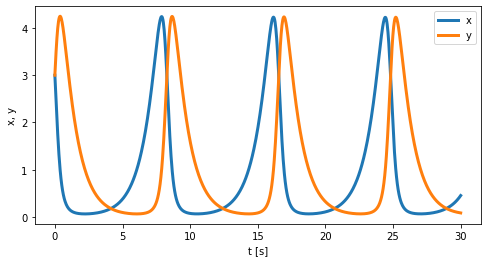

In [76]:
# Integrate ODE
sol = solve_ivp(ClassicLotkaVolterra, [ti, tf], x0, method='LSODA', t_eval=t)

plt.figure(figsize=(8,4));
plt.plot(t,sol.y.T, linewidth=3);
plt.xlabel("t [s]");
plt.ylabel("x, y");
plt.legend(["x","y"]);

# Hamiltonian Lotka-Volterra

Change of variables:

$$
    \begin{bmatrix}
        q\\
        p
    \end{bmatrix} =
    \begin{bmatrix}
        \log(y)\\
        \log(x)
    \end{bmatrix}
$$

The Lotka-Volterra model becomes a Hamiltonian system

$$
    \begin{bmatrix}
        \dot{q}\\
        \dot{p}
    \end{bmatrix} =
    \begin{bmatrix}
        0 & 1\\
       -1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        \partial_q \mathcal{H}\\
        \partial_p \mathcal{H}
    \end{bmatrix}
$$
with 
$$
    \mathcal{H}(q,p) = -aq + be^{q} -cp + de^{p}
$$

In [77]:
def HamLotkaVolterra(t,x):
    dqdt = -c + d*np.exp(x[1])
    dpdt =  a - b*np.exp(x[0])
    return np.array([dqdt, dpdt]).T

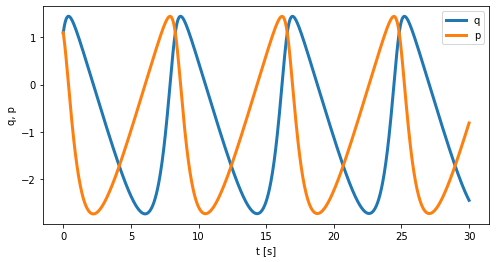

In [78]:
# Integrate ODE
sol = solve_ivp(HamLotkaVolterra, [ti, tf], [np.log(x0[1]),np.log(x0[0])], method='LSODA', t_eval=t)

plt.figure(figsize=(8,4));
plt.plot(t,sol.y.T, linewidth=3);
plt.xlabel("t [s]");
plt.ylabel("q, p");
plt.legend(["q","p"]);

## Compare "Classic" and Hamiltonian Dynamics

- foliation of trajectories
- Shape of the energy/motion integral

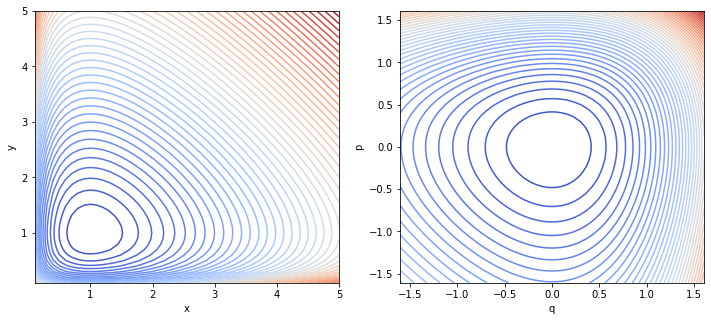

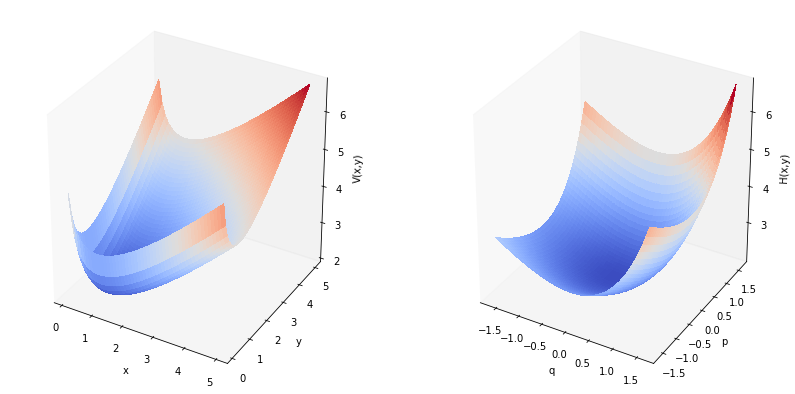

In [121]:
def MotionIntegral(x): return -a*np.log(x[1]) - c*np.log(x[0]) + b*x[1] + d*x[0] 
def Hamiltonian (x):   return -a*x[0] + b*np.exp(x[0]) - c*x[1] + d*np.exp(x[1])

Np = 50
lim = 5
x = np.linspace(0.1, lim, Np)
X, Y = np.meshgrid(x,x)

q = np.linspace(-np.log(lim), np.log(lim), Np)
#q = np.linspace(-5,5, Np)
Q, P = np.meshgrid(q,q)

Vgrid = np.zeros((Np,Np))
Hgrid = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        Vgrid[i,j] = MotionIntegral([X[i,j],Y[i,j]])
        Hgrid[i,j] = Hamiltonian([Q[i,j],P[i,j]])
        
        
fig = plt.figure(figsize=(12,5))
#
ax = fig.add_subplot(121)
surf = ax.contour(X, Y, Vgrid, 50, cmap=cm.coolwarm)
ax.grid(False)
ax.set_xlabel("x");
ax.set_ylabel("y");
#
ax = fig.add_subplot(122)
surf = ax.contour(Q, P, Hgrid, 50, cmap=cm.coolwarm)
ax.grid(False)
ax.set_xlabel("q");
ax.set_ylabel("p");

fig = plt.figure(figsize=(14,7))
#
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, Vgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.grid(False)
ax.set_xlabel("x");
ax.set_ylabel("y");
ax.set_zlabel("V(x,y)");
#
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(Q, P, Hgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.grid(False)
ax.set_xlabel("q");
ax.set_ylabel("p");
ax.set_zlabel("H(x,y)");

# Controlled System

$$
    \begin{bmatrix}
        \dot{q}\\
        \dot{p}
    \end{bmatrix} =
    \begin{bmatrix}
        0 & 1\\
       -1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        \partial_q \mathcal{H}\\
        \partial_p \mathcal{H}
    \end{bmatrix} + u
$$

The control law $u$ is made up by two distinct actions: the "energy shaping" $\beta$ and the "damping injection" $v$

$$
    u = \beta + v
$$

Feedforward Action (energy shaping):

$$
    \begin{bmatrix}
        \partial_q \mathcal{H}\\
        \partial_p \mathcal{H}
    \end{bmatrix} + u
$$


In [108]:
def ControlLotkaVolterra(t,x):
    dqdt = d*(-xd + np.exp(x[1]))
    dpdt = b*( yd - np.exp(x[0]))
    return np.array([dqdt+Kd*dpdt, dpdt]).T

In [109]:
X = []
Nsim = 100
sigma = .1

for i in range(Nsim):
    x0 = sigma*np.random.randn(2)
    sol = solve_ivp(lotkaVolterra, [ti, tf], x0, method='LSODA',t_eval=t)
    X.append(sol.y.T)

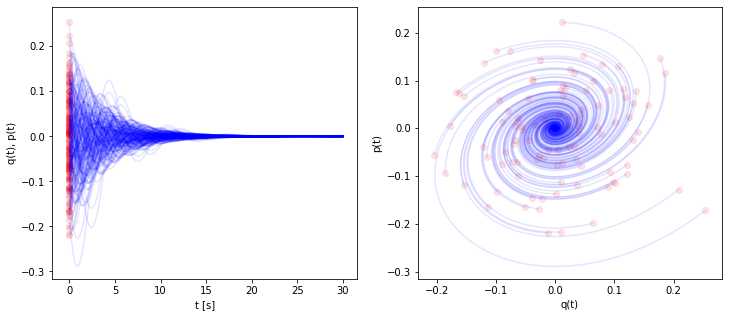

In [22]:
plt.figure(figsize=(12,5))
#
plt.subplot(121)
for i in range(Nsim):
    plt.plot(t,X[i], color = 'blue', alpha = .1)
for i in range(Nsim):
    plt.scatter([0.,0.],X[i][0,:], color = 'red', alpha = .1)
plt.xlabel("t [s]")
plt.ylabel("q(t), p(t)");
#
plt.subplot(122)
for i in range(Nsim):
    plt.plot(X[i][:,0],X[i][:,1], color = 'blue', alpha = .1)
for i in range(Nsim):
    plt.scatter(X[i][0,0],X[i][0,1], color = 'red', alpha = .1)
plt.xlabel("q(t)");
plt.ylabel("p(t)");

In [79]:
def ControlledHamiltonian(x): return  d*(-xd*x[1] + np.exp(x[1])) + b*(-yd*x[0] + np.exp(x[0]))

In [24]:
H = []
for i in range(Nsim):
    H.append([Hamiltonian(p) for p in X[i]])

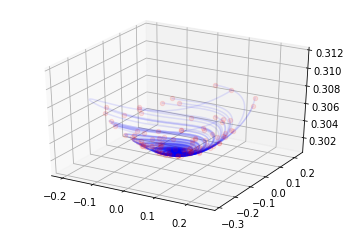

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(Nsim):
    ax.plot(X[i][:,0],X[i][:,1],np.log10(H[i]),color='blue', alpha = .1)
for i in range(Nsim):
    ax.scatter(X[i][0,0],X[i][0,1],np.log10(H[i][0]),color='red', alpha = .1)    

IndexError: too many indices for array

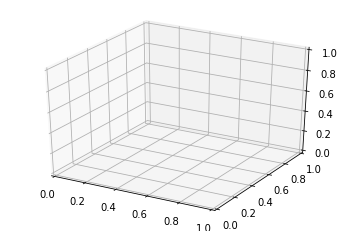

In [128]:
Np = 50
u = np.linspace(-10, 5, Np)
U, V = np.meshgrid(u,u)
Hgrid = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        Hgrid[i,j] = np.log10(Hamiltonian([U[i,j],V[i,j]]))
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(Nsim):
    ax.plot(X[i][:,0],X[i][:,1],np.log10(H[i]),'blue', alpha = .2)
surf = ax.plot_surface(U, V, Hgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    

In [122]:
x0 = [1,1]
X_k = []
N_k = 2000
K = np.linspace(0.01,2,N_k)
for i in range(N_k):
    Kd = K[i]
    sol = solve_ivp(lotkaVolterra, [ti, tf], x0, method='RK45',t_eval=t)
    X_k.append(sol.y.T)

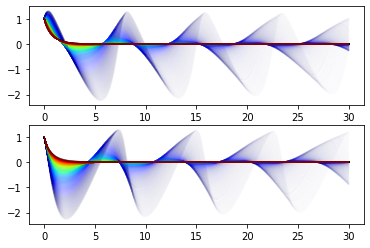

In [126]:
colors = plt.cm.jet(np.linspace(0,1,N_k))

plt.figure()
plt.subplot(211)
for i in range(N_k):
    plt.plot(t,X_k[i][:,0],color=colors[i], alpha = .01)
plt.subplot(212)
for i in range(N_k):
    plt.plot(t,X_k[i][:,1],color=colors[i], alpha = .01)

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

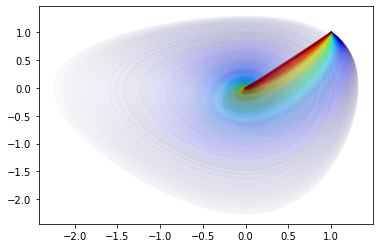

In [125]:
plt.figure()
for i in range(N_k):
    plt.plot(X_k[i][:,0],X_k[i][:,1],color=colors[i], alpha = .01)
plt.colorbar